In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import imutils


2023-10-13 09:02:39.463013: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 09:02:39.705699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-13 09:02:39.705786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-13 09:02:39.706600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-13 09:02:39.807057: I tensorflow/core/platform/cpu_feature_g

In [2]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged


In [3]:
def getImgContours(edged):
    # find contours in the edge map
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [4]:
def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

In [5]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (128,128)

In [6]:
def load_data(path):

    datasets = [path]
    images = []
    labels = []

    # iterate through training and test sets
    count =0
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open 
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # add padding to the image to better detect cell at the edge
                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
                #thresholding the image to get the target cell
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
                # openning errosion then dilation
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
                #detecting the blood cell
                edgedImage = findEdges(image1)
                edgedContours = getImgContours(edgedImage)
                edgedBoxes =  getBoxes(edgedContours, image.copy())
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                # get the large box and get its cordinate
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                # draw the contour and fill it 
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
                # any pixel but the pixels inside the contour is zero
                image[mask==0] = 0
                
                # extract th blood cell
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                # resize th image
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [7]:
images, labels = load_data(path='/home/user/Desktop/personal/jui/for_Report/generated')
images_t, labels_t = load_data(path='/home/user/Desktop/personal/jui/for_Report/images/TEST')

100%|██████████| 620/620 [00:00<00:00, 659.69it/s]


In [8]:
images, labels = shuffle(images, labels, random_state=10)
test_images, test_labels = shuffle(images_t, labels_t, random_state=10)

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.2)


In [9]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))


Number of training examples: 15537
Number of validation examples: 3885
Number of testing examples: 2427
Training images are of shape: (15537, 128, 128, 3)
Training labels are of shape: (15537,)
Validation images are of shape: (3885, 128, 128, 3)
Validation labels are of shape: (3885,)
Test images are of shape: (2427, 128, 128, 3)
Test labels are of shape: (2427,)


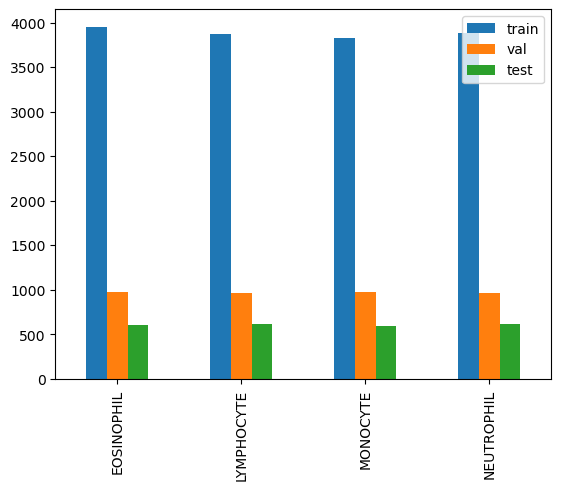

In [10]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

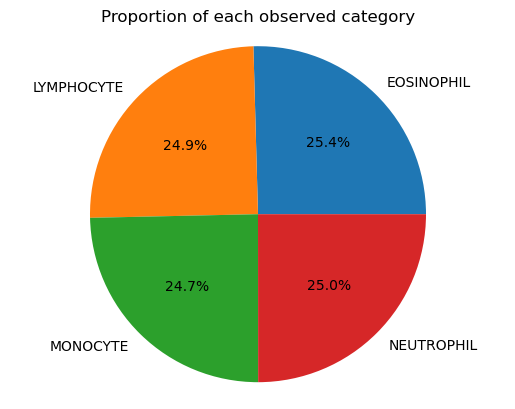

In [11]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

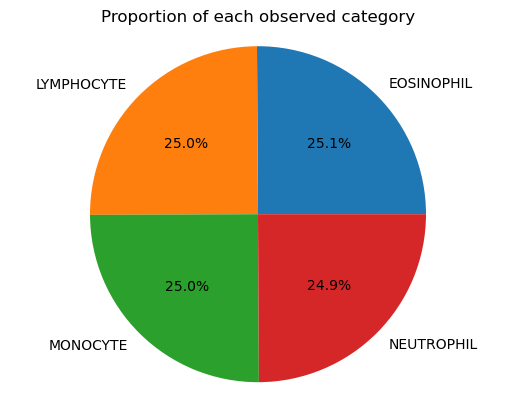

In [12]:
plt.pie(val_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

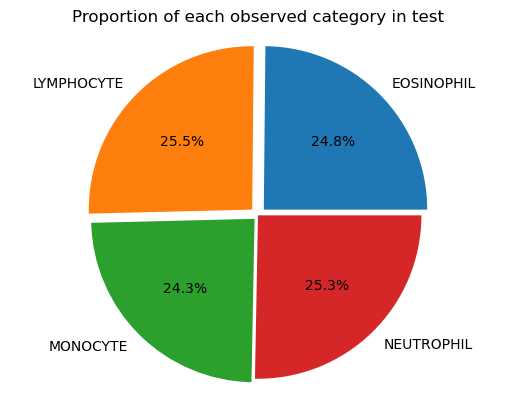

In [13]:
plt.pie(test_counts,
        explode=(0.05, 0.05, 0.03, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category in test')
plt.show()

In [14]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

15537


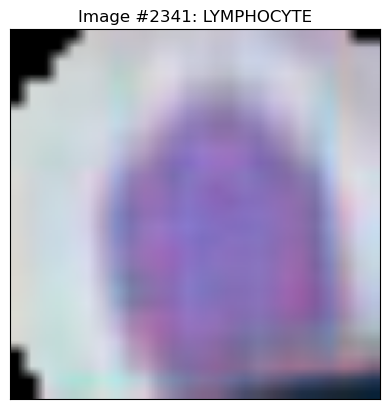

In [15]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

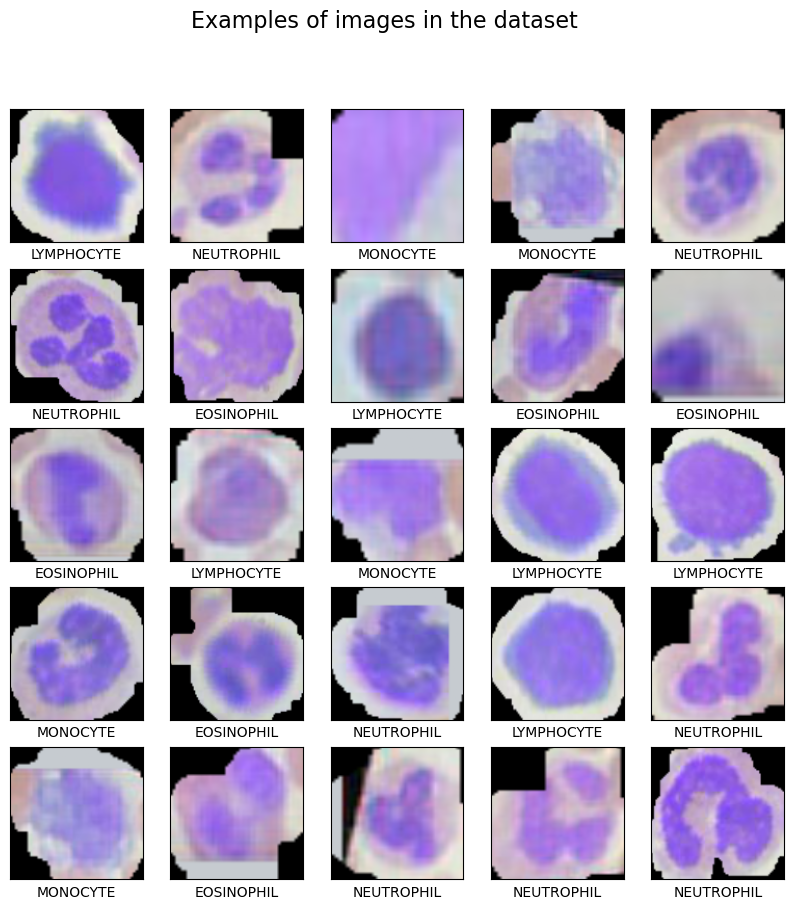

In [16]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

In [17]:
from tensorflow.keras.applications import Xception, MobileNet, VGG19
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Concatenate


base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


for layer in base_model.layers:
    layer.trainable = True


input_layer = Input(shape=(128, 128, 3))

x = base_model(input_layer)


x = GlobalAveragePooling2D()(x)

x = Dense(units=1024, activation='relu')(x)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=256, activation='relu')(x)

predictions = Dense(4, activation='softmax')(x)

# Create the final model
model1 = Model(inputs=input_layer, outputs=predictions)
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='/home/user/Desktop/personal/jui/for_Report/Weights/mobilenet.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)
import time
start_time = time.time()
# Train
history1 = model1.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 30, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])


end_time = time.time()

2023-10-13 09:04:34.926024: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-13 09:04:35.030725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-13 09:04:35.031025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

17225924/17225924 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                              

2023-10-13 09:04:45.046792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-13 09:04:45.839047: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-13 09:04:46.573803: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-13 09:04:46.614989: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f35b4658820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-13 09:04:46.615005: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2023-10-13 09:04:46.618909: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-13 09:04:46.679671: I ./tensorflow/compiler/jit/device_comp

486/486 [==============================] - 32s 46ms/step - loss: 0.2540 - accuracy: 0.9130 - val_loss: 0.1761 - val_accuracy: 0.9395 - lr: 0.0010
Epoch 2/30
486/486 [==============================] - 21s 42ms/step - loss: 0.1457 - accuracy: 0.9545 - val_loss: 0.2401 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 3/30
485/486 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9696
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
486/486 [==============================] - 20s 42ms/step - loss: 0.0933 - accuracy: 0.9694 - val_loss: 0.2110 - val_accuracy: 0.9380 - lr: 0.0010
Epoch 4/30
486/486 [==============================] - 21s 43ms/step - loss: 0.0342 - accuracy: 0.9881 - val_loss: 0.0273 - val_accuracy: 0.9887 - lr: 3.0000e-04
Epoch 5/30
486/486 [==============================] - 21s 43ms/step - loss: 0.0191 - accuracy: 0.9927 - val_loss: 0.0205 - val_accuracy: 0.9915 - lr: 3.0000e-04
Epoch 6/30
486/486 [==============================] - 20s

In [18]:
print("Execution time:", end_time - start_time, "seconds")

Execution time: 629.150545835495 seconds


# Evaluating performance

Following model training I emplemented a helper function to plot Accuracy vs Epoch and Loss vs Epoch for both the Training and Validation sets


In [19]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(30)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

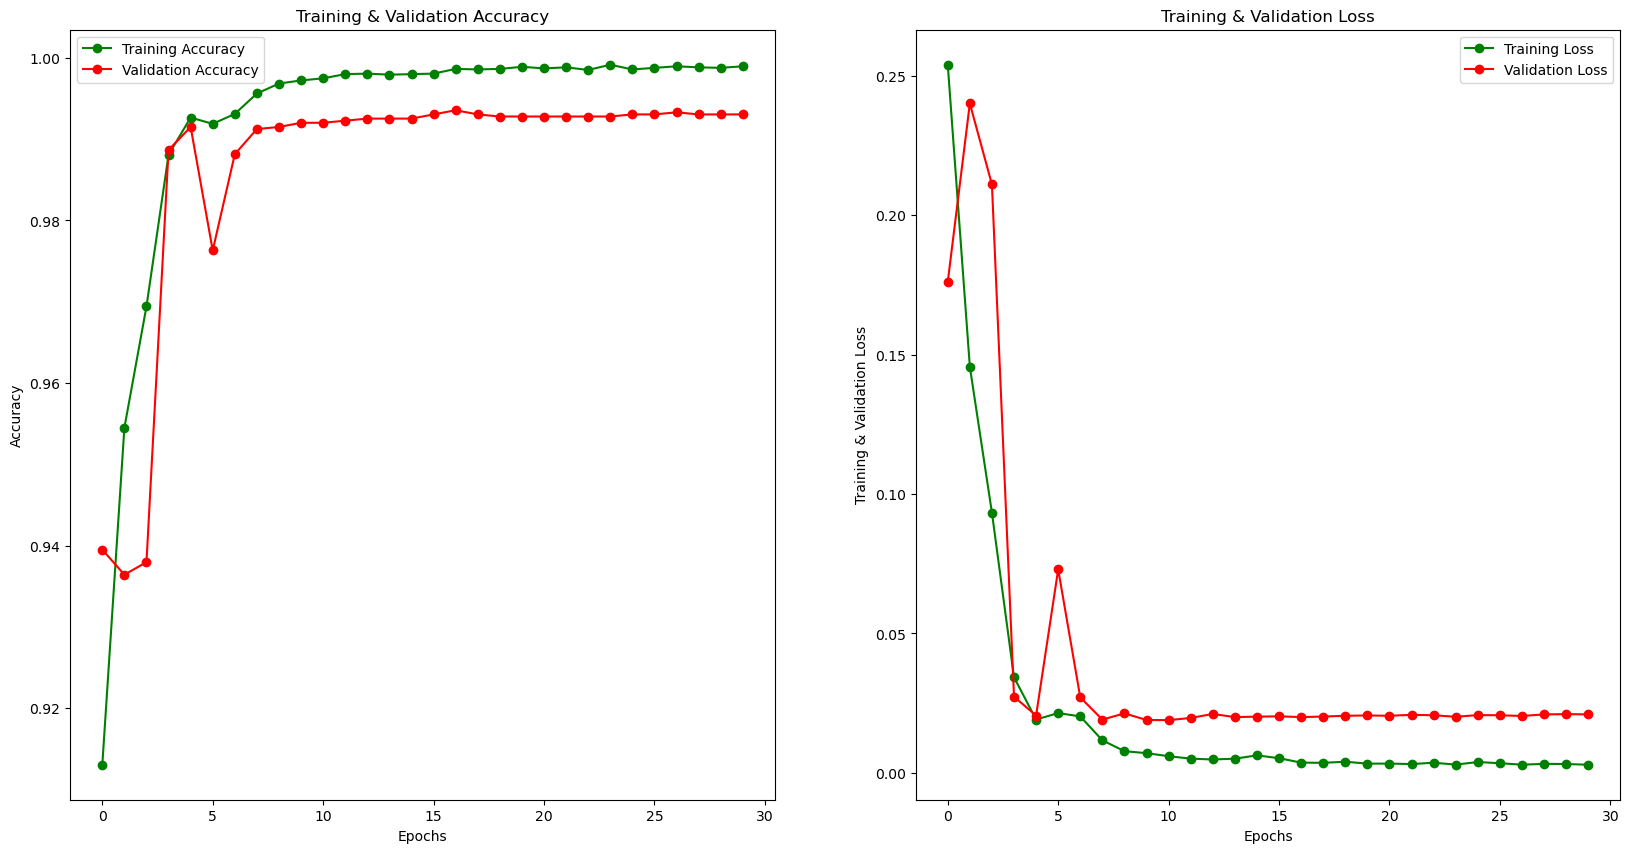

In [20]:
plot_accuracy_loss_chart(history1)

Lets evaluate the model on test data to find the loss and accuracy:


In [21]:

results = model1.evaluate(test_images, test_labels)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")


results = model1.evaluate(val_images, val_labels)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%")


76/76 [==============================] - 1s 19ms/step - loss: 1.7815 - accuracy: 0.8599
Loss of the model  is - test  1.7815111875534058
Accuracy of the model is - test 85.99093556404114 %
122/122 [==============================] - 2s 18ms/step - loss: 0.0209 - accuracy: 0.9931
Loss of the model  is - val  0.020945176482200623
Accuracy of the model is - val 99.3050217628479 %


Model (and weights) are saved after training. The best model and its weights can also be saved using the ModelCheckpoint callback if "EarlyStopping" is activated in the Model.fit phase. [More on this here](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

I decided against using EarlyStopping, but I will try to include it in future work on this dataset. 

In [22]:
model1.save('/home/user/Desktop/personal/jui/for_Report/Weights/mobilenet.h5')

/home/user/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model_weight = tf.keras.models.load_model('/home/user/Desktop/personal/jui/for_Report/Weights/mobilenet.h5')

In [25]:
from sklearn.metrics import classification_report

predictions = model_weight.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

76/76 [==============================] - 1s 12ms/step


array([3, 0, 3, 1, 1, 1, 3, 0, 3, 0, 0, 0, 2, 0, 1])

In [26]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.87      0.85      0.86       603
LYMPHOCYTE (Class 1)       1.00      0.99      0.99       620
  MONOCYTE (Class 2)       1.00      0.72      0.83       590
NEUTROPHIL (Class 3)       0.68      0.88      0.76       614

            accuracy                           0.86      2427
           macro avg       0.88      0.86      0.86      2427
        weighted avg       0.88      0.86      0.86      2427



In [27]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,514,2,1,86
1,1,612,0,7
2,2,0,422,166
3,74,0,1,539


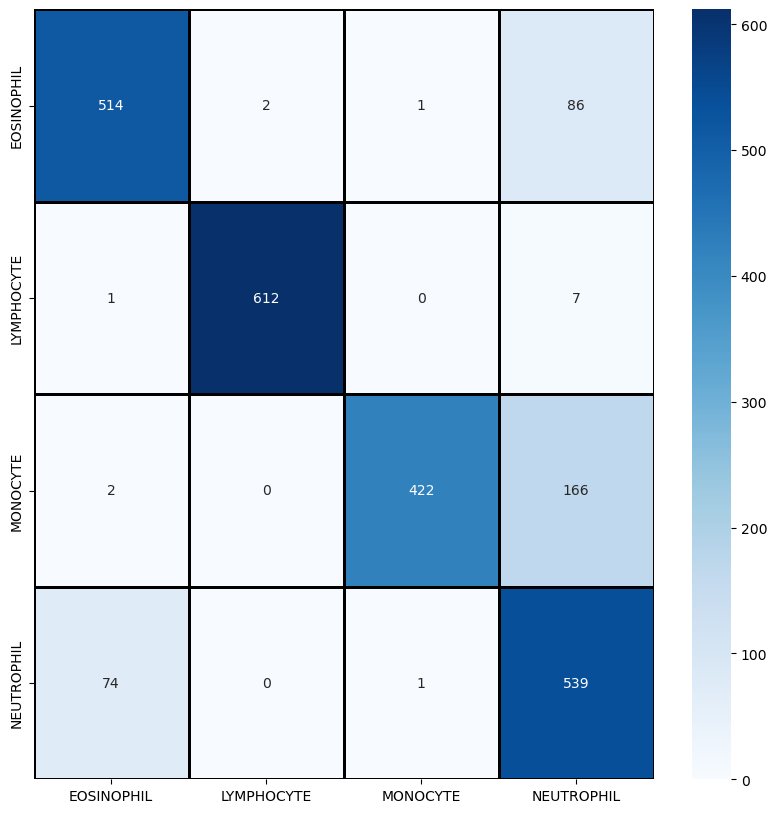

In [28]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

: 